# 強化学習のmelowmaxについて

今日はこの[論文](https://arxiv.org/abs/1612.05628)について説明していきます．

強化学習の更新式は次のように書かれます．

$$
Q(s,a) \leftarrow R(s,a) + \gamma \sum_{\hat{s} \in S} P(s,a,\hat{s})\bigotimes_{\hat{a}} Q(\hat{s},\hat{a})
$$

ここで, $Q$ は状態行動価値関数で, $R$ は報酬関数, $\gamma$ は $(0,1]$ で $P$ は確率遷移関数とします.

ここで問題となってくるのは, $\bigotimes$ にどんな作用素を持ってくるのかです．

見慣れている形(Q学習など)は $\max$ をとっていますね．

ここで色々な作用素の特徴を上の論文に準じて述べていきます．

---

ここからは $\mathbf X = x_1 , ..., x_n$ とします．

### $\max$ 作用素について

$$
\max{\mathbf X} = \max_{i \in (x_1,...,x_n)}x_i
$$

この作用素のメリットとしてはnon-expansionということになります．つまり, ある不動店に収束すると保証されます．

デメリットは微分ができない, 最大化する部分以外の要素を無視していることです．

しかしながら, 実装の容易さやシンプルであることから重宝されていますね．


---

### mean 作用素について

$$
mean(\mathbf{X}) = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

この作用素はメリットとしてはnon-expantionでありながら, 微分可能です．

しかしながら, 価値が高いものと低いものの判断が平均によって評価しずらくなってしまいます．



---

### ボルツマン作用素について

$$
boltz_{\beta}(\mathbf{X}) = \frac{\sum_{i=1}^{n} x_i e^{\beta x_i}}{\sum_{i=1}^{n}e^{\beta x_i}}
$$

この作用素は微分可能で, 価値が高いものと低いものの区別もしてくれるようになっていますが, non-expantionでないとが知られています．

ちなみに $\beta \rightarrow \infty$ で $\max$ 作用素, $\beta \rightarrow 0$ で　$mean$ 作用素と同じ働きをします．

---

上の論文ではこのボルツマン作用素に似ているものを考えて, かつnon-expantionである作用素を提案することを目的としています．

それが $mellowmax$ です．

まず式を確認します．

---

### $mellowmax$ 作用素について

$$
mm_\omega\mathbf(X) = \frac{log(\frac{1}{n} \sum_{i=1}^{n} e^{\omega x_i})}{\omega}
$$

上の作用素はnon-expantionであることが論文中で示されています．

---

早速コードを書いていきます．

In [22]:
import numpy as np
from typing import NamedTuple

S = 100 #state_size
A = 10  #action_size
S_array = np.arange(S) #state_set
A_array = np.arange(A) #action_set
gamma = 0.99 

rew = np.random.rand(S,A) * 10 #報酬

P = np.random.rand(S*A, S) #遷移確率
P = P / np.sum(P,axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_almost_equal(P.sum(axis=-1),1) #確率1になっているか確認

# MDPの定義

class MDP(NamedTuple):
    S_array : np.array
    A_array : np.array
    gamma : float
    rew : np.array
    P : np.array

    @property
    def S(self) -> int:
        return len(self.S_array)

    @property
    def A(self) -> int:
        return len(self.A_array)

mdp = MDP(S_array,A_array,gamma,rew,P)
print(mdp.rew.shape)
print(mdp.P.shape)

(100, 10)
(100, 10, 100)


In [23]:
import jax
import jax.numpy as jnp
from functools import partial


# @partial(jax.jit,static_argnames=('q','beta'))
@jax.jit
def mellowmax_operator(mdp:MDP, q:np.ndarray, beta:float):
    S,A = mdp.S,mdp.A
    exp_beta_q = jnp.exp(beta*q - (beta*q).max())
    pi = exp_beta_q  / np.sum(exp_beta_q,axis=-1,keepdims=True) 
    
    v = (pi * q).sum(axis=1)
    P_v = mdp.P @ v

    return mdp.rew + mdp.gamma * P_v



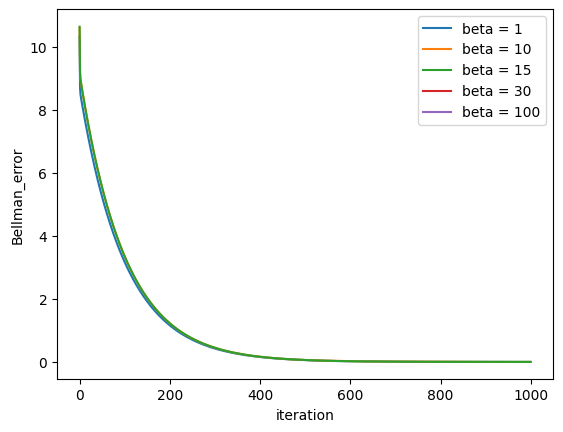

In [24]:
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(0)

S,A = mdp.S, mdp.A

betas = [1,10,15,30,100]
for beta in betas:
    q_before = jax.random.uniform(key = key,shape = (S,A))
    errors = []


    

    for i in range(1000):
        q_after = mellowmax_operator(mdp,q_before,beta)
        errors.append(np.abs(q_after - q_before).max())

        q_before = q_after
    plt.plot(errors,label=f'beta = {beta}')

plt.ylabel('Bellman_error')
plt.xlabel('iteration')
plt.legend()

収束していますね．